## 📘 Notebook Summary: Analyzing Semantic Similarity Across Terms of Service (ToS)

### Objective

The goal of this analysis was to examine whether Terms of Service (ToS) documents from various companies and categories exhibit semantically meaningful differences. The focus was on assessing whether natural language embeddings can reveal category-specific patterns or similarities in contractual clauses.

### Key Findings

Cosine Similarities
BERT and SentenceTransformer embeddings show very small differences between within- and between-category similarities, indicating that category labels do not correspond to distinct semantic structures.

Statistical Tests
Both ANOVA and Kruskal-Wallis tests found no significant differences in similarity distributions across categories (p > 0.05), for both embedding models.

Dimensionality Reduction
Visualizations with UMAP, PCA, and t-SNE revealed no meaningful clustering by category, further supporting the finding of semantic overlap across categories.

Clause-Level Overlap
Document-level graph analysis shows limited high-similarity overlaps (10%+ shared n-grams), likely due to reused legal templates. These overlaps are sparse and not confined to category boundaries.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy.stats import f_oneway, kruskal
import pickle
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import re
from sklearn.feature_extraction.text import CountVectorizer
from itertools import combinations
import networkx as nx
import os
import warnings
from clean_text import preprocess_text
warnings.filterwarnings('ignore')

c:\Users\kaszt\OneDrive\Dokumenty\ml_law\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('data/company_embeddings/embeddings_sentence_trans.pkl', 'rb') as f:
    embeddings_sentence = pickle.load(f)

with open('data/company_embeddings/embeddings_cleaned.pkl', 'rb') as f:
    embeddings_word = pickle.load(f)

df = pd.read_csv('data/terms_of_service.csv')

similarity_matrix_word = pd.read_csv('data/company_similarity/similarity_cleaned.csv', index_col=0)
similarity_matrix_sentence = pd.read_csv('data/company_similarity/similarity_sentence_trans.csv', index_col=0)

company_names = similarity_matrix_word.columns[1:]
company_to_category = dict(zip(df['Company'], df['Category']))
categories = [company_to_category.get(name, "Unknown") for name in company_names]

## Simmilarity Within-Category vs Between-Category

In [3]:
def build_similarity_stats(embeddings_dict, df):
    valid_companies = []
    embedding_matrix = []
    categories = []

    for _, row in df.iterrows():
        filename = f"{row['Company'].lower().replace(' ', '')}.txt"
        if filename in embeddings_dict:
            valid_companies.append(row['Company'])
            embedding_matrix.append(embeddings_dict[filename])
            categories.append(row['Category'])

    embedding_matrix = np.array(embedding_matrix)
    similarity_matrix = cosine_similarity(embedding_matrix)

    within_category = []
    between_category = []

    n = len(valid_companies)
    for i in range(n):
        for j in range(i + 1, n):
            sim = similarity_matrix[i, j]
            if categories[i] == categories[j]:
                within_category.append(sim)
            else:
                between_category.append(sim)

    return within_category, between_category

In [4]:
within_word, between_word = build_similarity_stats(embeddings_word, df)
within_sent, between_sent = build_similarity_stats(embeddings_sentence, df)

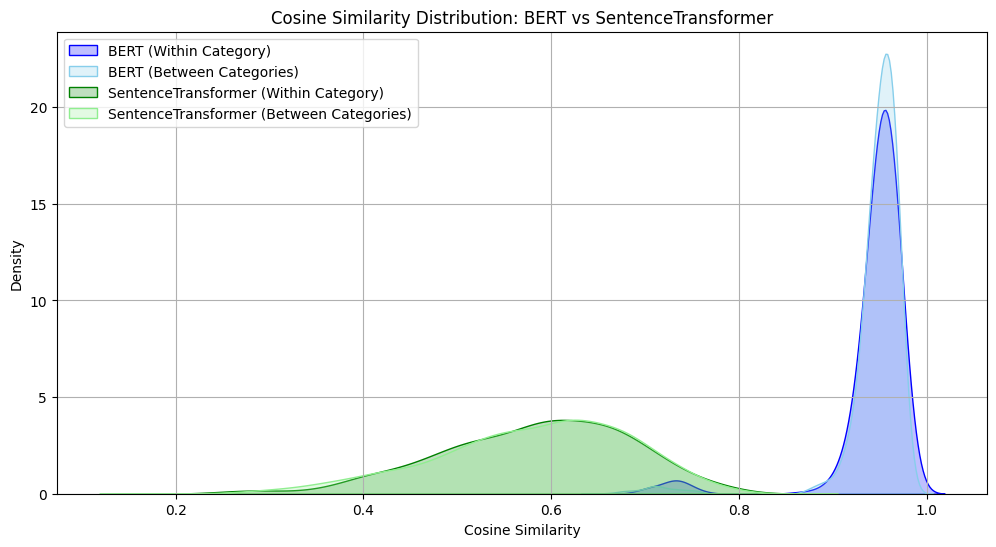

In [5]:
plt.figure(figsize=(12, 6))

sns.kdeplot(within_word, label='BERT (Within Category)', shade=True, color='blue')
sns.kdeplot(between_word, label='BERT (Between Categories)', shade=True, color='skyblue')

sns.kdeplot(within_sent, label='SentenceTransformer (Within Category)', shade=True, color='green')
sns.kdeplot(between_sent, label='SentenceTransformer (Between Categories)', shade=True, color='lightgreen')

plt.title('Cosine Similarity Distribution: BERT vs SentenceTransformer')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
print("📊 Mean Cosine Similarities")
print("BERT (Within):", np.mean(within_word))
print("BERT (Between):", np.mean(between_word))
print("SentenceTransformer (Within):", np.mean(within_sent))
print("SentenceTransformer (Between):", np.mean(between_sent))


📊 Mean Cosine Similarities
BERT (Within): 0.94394475
BERT (Between): 0.9457247
SentenceTransformer (Within): 0.58339196
SentenceTransformer (Between): 0.581786


In [7]:
print("\n🔬 ANOVA Test Results")
f_val_word, p_val_word = f_oneway(within_word, between_word)
print(f"BERT:        F = {f_val_word:.3f}, p = {p_val_word:.4f}")

f_val_sent, p_val_sent = f_oneway(within_sent, between_sent)
print(f"SentenceTrans: F = {f_val_sent:.3f}, p = {p_val_sent:.4f}")



🔬 ANOVA Test Results
BERT:        F = 0.798, p = 0.3717
SentenceTrans: F = 0.094, p = 0.7589


In [8]:
print("\n📈 Kruskal-Wallis Test Results")
h_val_word, p_val_word = kruskal(within_word, between_word)
print(f"BERT:        H = {h_val_word:.3f}, p = {p_val_word:.4f}")

h_val_sent, p_val_sent = kruskal(within_sent, between_sent)
print(f"SentenceTrans: H = {h_val_sent:.3f}, p = {p_val_sent:.4f}")


📈 Kruskal-Wallis Test Results
BERT:        H = 0.023, p = 0.8786
SentenceTrans: H = 0.004, p = 0.9526


📊 Mean Cosine Similarities

    BERT: Within-group (0.944) and between-group (0.946) similarity scores are nearly identical, suggesting little differentiation across categories.

    SentenceTransformer: Also shows minimal distinction between within-group (0.583) and between-group (0.582) similarities.

🔬 ANOVA Test Results

    No statistically significant difference in cosine similarities across categories for either embedding model (BERT: p = 0.37, ST: p = 0.76).

📈 Kruskal-Wallis Test Results

    Non-parametric tests confirm the lack of significant group differences (BERT: p = 0.88, ST: p = 0.95).

## Category-Level Analysis

In [9]:
def category_similarity_analysis(similarity_matrix, categories, model_name="Model"):
    n = len(categories)

    category_pairs = []
    similarities = []
    melted_data = []

    for i in range(n):
        for j in range(i+1, n):
            pair = tuple(sorted((categories[i], categories[j])))
            category_pairs.append(pair)
            similarities.append(similarity_matrix.values[i, j])

            melted_data.append({
                'Category1': categories[i],
                'Category2': categories[j],
                'Similarity': similarity_matrix.values[i, j]
            })

    category_df = pd.DataFrame({
        'Category Pair': category_pairs,
        'Similarity': similarities
    })
    category_df['Same Category'] = category_df['Category Pair'].apply(lambda x: x[0] == x[1])

    melted_df = pd.DataFrame(melted_data)
    same_category = melted_df[melted_df['Category1'] == melted_df['Category2']].copy()
    same_category['Comparison'] = same_category['Category1']
    
    diff_category = melted_df[melted_df['Category1'] != melted_df['Category2']].copy()
    diff_category['Comparison'] = "Different Categories"

    tukey_data = pd.concat([same_category, diff_category])

    plt.figure(figsize=(12, 8))
    sns.boxplot(data=same_category, x='Category1', y='Similarity')
    plt.title(f'{model_name}: Similarity Distributions Within Categories')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    tukey_results = pairwise_tukeyhsd(
        endog=tukey_data['Similarity'],
        groups=tukey_data['Comparison'],
        alpha=0.05
    )
    print(f"\n📊 Tukey HSD Results for {model_name}:")
    print(tukey_results)

    return category_df, melted_df

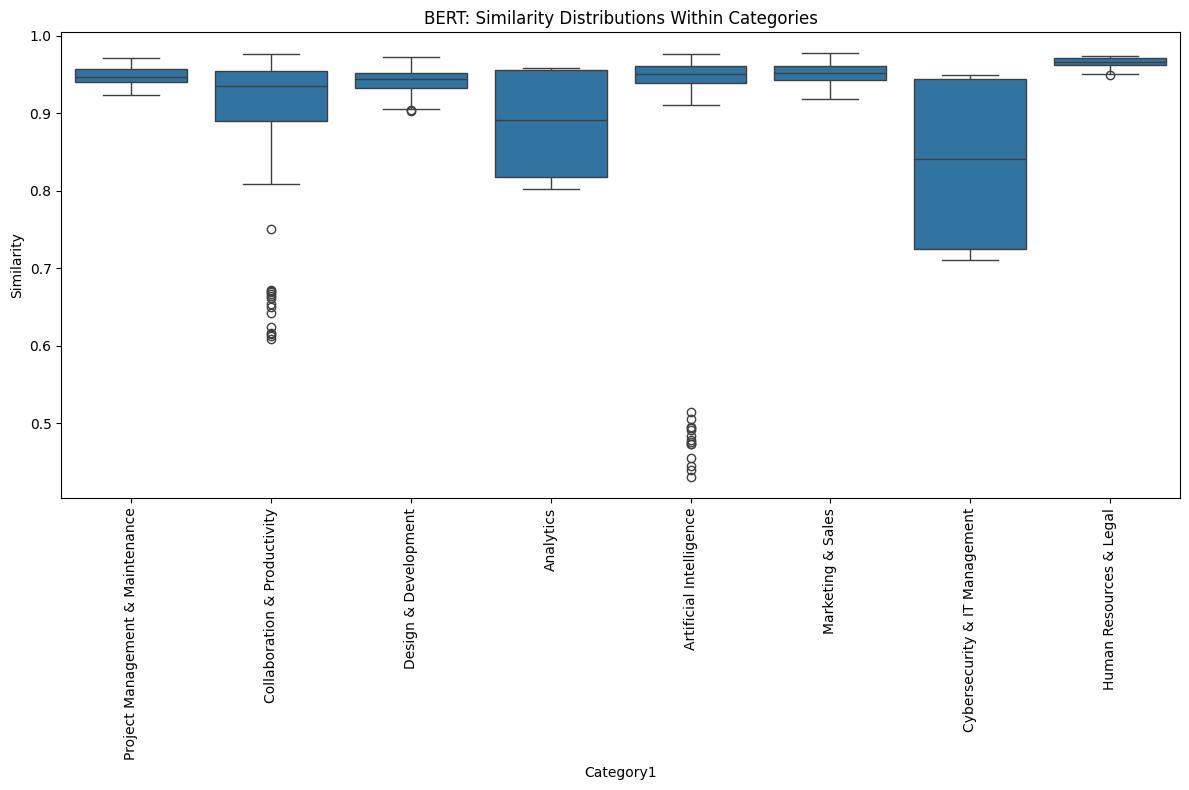


📊 Tukey HSD Results for BERT:
                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
            group1                         group2              meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------------------------------------
                    Analytics          Artificial Intelligence    0.003    1.0 -0.1177 0.1238  False
                    Analytics     Collaboration & Productivity   0.0128    1.0 -0.1072 0.1328  False
                    Analytics    Cybersecurity & IT Management  -0.0515 0.9891 -0.2175 0.1146  False
                    Analytics             Design & Development    0.055 0.9103   -0.07 0.1801  False
                    Analytics             Different Categories    0.034 0.9931 -0.0835 0.1516  False
                    Analytics          Human Resources & Legal   0.0788 0.6582 -0.0544 0.2119  False
                    Analytics                Marketing & Sal

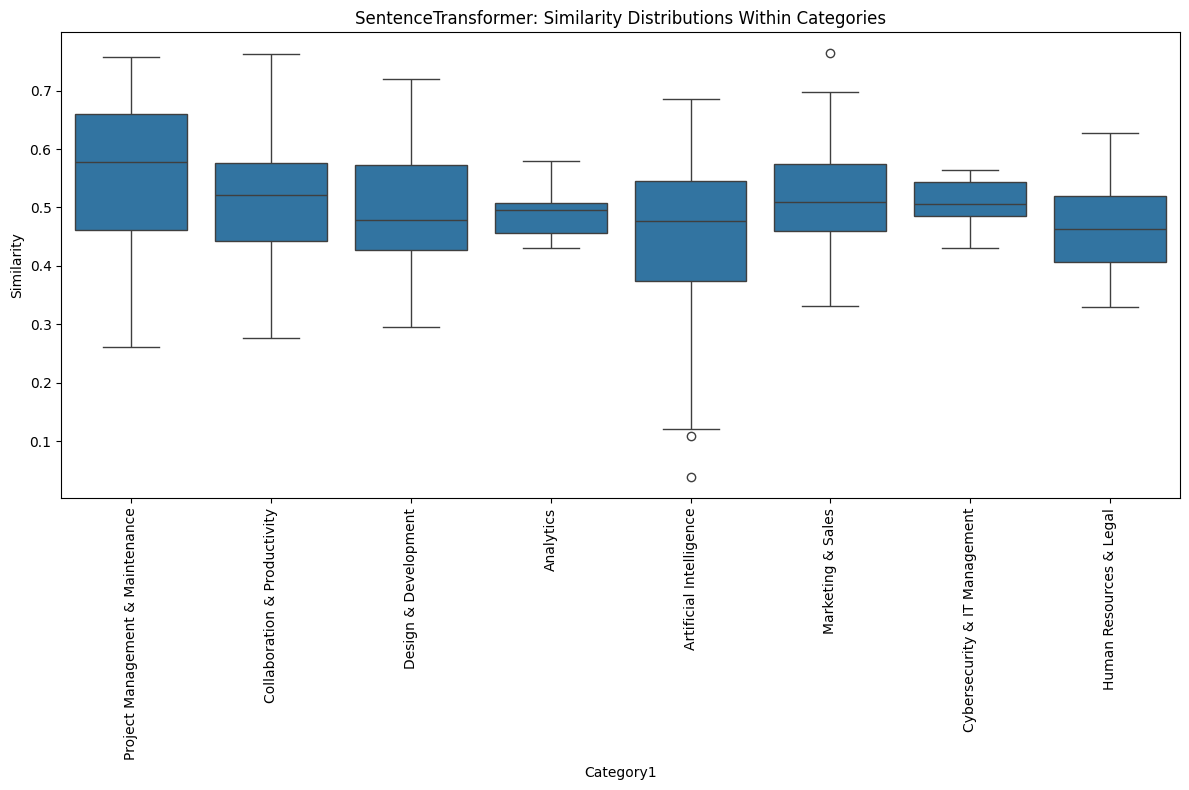


📊 Tukey HSD Results for SentenceTransformer:
                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
            group1                         group2              meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------------------------------------
                    Analytics          Artificial Intelligence  -0.0503 0.9771 -0.1949 0.0943  False
                    Analytics     Collaboration & Productivity   0.0174    1.0 -0.1263 0.1611  False
                    Analytics    Cybersecurity & IT Management   0.0142    1.0 -0.1847 0.2131  False
                    Analytics             Design & Development   0.0054    1.0 -0.1443 0.1551  False
                    Analytics             Different Categories  -0.0017    1.0 -0.1425 0.1391  False
                    Analytics          Human Resources & Legal  -0.0351  0.999 -0.1946 0.1243  False
                    Analytics                

In [10]:
category_df_word, melted_df_word = category_similarity_analysis(similarity_matrix_word, categories, model_name="BERT")
category_df_sent, melted_df_sent = category_similarity_analysis(similarity_matrix_sentence, categories, model_name="SentenceTransformer")

BERT embeddings capture slightly higher similarity within certain categories, particularly for Artificial Intelligence.

SentenceTransformer embeddings reveal moderate semantic differentiation across some category boundaries—especially those involving Artificial Intelligence.

Both BERT and SentenceTransformer find majority of categories not significantly different, indicating substantial overlap in clause similarity across domains.

## Employee Size Analysis

In [11]:
def process_mean_similarity(similarity_matrix, embeddings, df, model_name="Model"):
    company_data = []
    for _, row in df.iterrows():
        filename = f"{row['Company'].lower().replace(' ', '')}.txt"
        if filename in embeddings:
            company_data.append({
                'Company': row['Company'],
                'Category': row['Category'],
                'Employees': row['Employees'],
                'Filename': filename
            })
    
    employee_df = pd.DataFrame(company_data)

    if isinstance(similarity_matrix, pd.DataFrame):
        similarity_matrix = similarity_matrix.loc[employee_df['Company'], employee_df['Company']].values

    mean_sims = []
    for i in range(len(employee_df)):
        sims = np.delete(similarity_matrix[i], i)
        mean_sims.append(np.mean(sims))
    
    employee_df['MeanSimilarity'] = mean_sims
    employee_df['Model'] = model_name
    return employee_df

In [12]:
df_word = process_mean_similarity(similarity_matrix_word, embeddings_word, df, model_name="BERT")
df_sentence = process_mean_similarity(similarity_matrix_sentence, embeddings_sentence, df, model_name="SentenceTransformer")
df_combined = pd.concat([df_word, df_sentence], ignore_index=True)

In [13]:
for model in ['BERT', 'SentenceTransformer']:
    print(f"\n📊 Model: {model}")
    subset = df_combined[df_combined['Model'] == model]
    
    groups = [
        subset[subset['Employees'] == size]['MeanSimilarity']
        for size in sorted(subset['Employees'].unique())
    ]

    h_stat, p_val = kruskal(*groups)
    print(f"Kruskal-Wallis p-value: {p_val:.4f}")

    if p_val < 0.05:
        tukey = pairwise_tukeyhsd(
            endog=subset['MeanSimilarity'],
            groups=subset['Employees'],
            alpha=0.05
        )
        print(tukey.summary())


📊 Model: BERT
Kruskal-Wallis p-value: 0.9084

📊 Model: SentenceTransformer
Kruskal-Wallis p-value: 0.8691


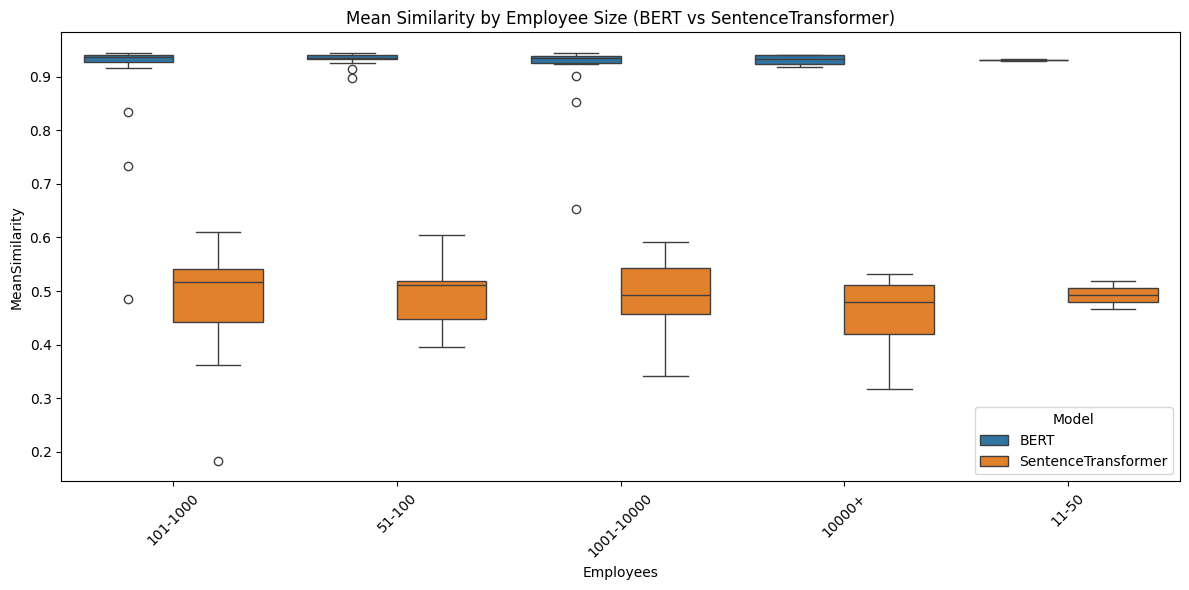

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_combined, x='Employees', y='MeanSimilarity', hue='Model')
plt.title("Mean Similarity by Employee Size (BERT vs SentenceTransformer)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Plot the embeddings

### UMAP

- UMAP - UMAP: Balances local/global structure preservation, faster than t-SNE and often better at retaining topology.
- PCA: Linear dimensionality reduction that maximizes variance while preserving global structure.
- t-SNE: Non-linear method focusing on local similarities, ideal for visualizing clusters in high-dimensional data.

In [15]:
def apply_dimensionality_reduction(X, method="umap"):
    if method == "umap":
        reducer = umap.UMAP(n_components=2, random_state=42)
    elif method == "pca":
        reducer = PCA(n_components=2)
    elif method == "tsne":
        reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    else:
        raise ValueError(f"Unknown method: {method}")
    return reducer.fit_transform(X)

In [16]:
def plot_projection(df, x_col, y_col, title, hue="Category"):
    plt.figure(figsize=(12, 9))
    sns.scatterplot(
        data=df,
        x=x_col,
        y=y_col,
        hue=hue,
        palette='tab10',
        s=60,
        alpha=0.8
    )
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True)
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [17]:
def process_and_plot_embeddings(embeddings, metadata_path, model_name="Model"):
    df = pd.DataFrame([
        {"filename": fname, "embedding": emb}
        for fname, emb in embeddings.items()
    ])
    df['Company'] = df['filename'].str.replace('.txt', '', regex=False)
    metadata = pd.read_csv(metadata_path)
    df = df.merge(metadata[['Company', 'Category']], on='Company', how='left')
    df['Model'] = model_name

    X = np.stack(df['embedding'].values)

    # UMAP
    umap_result = apply_dimensionality_reduction(X, method="umap")
    df['x_umap'], df['y_umap'] = umap_result[:, 0], umap_result[:, 1]
    plot_projection(df, 'x_umap', 'y_umap', f"{model_name} - UMAP Projection")

    # PCA
    pca_result = apply_dimensionality_reduction(X, method="pca")
    df['x_pca'], df['y_pca'] = pca_result[:, 0], pca_result[:, 1]
    explained = PCA(n_components=2).fit(X).explained_variance_ratio_
    print(f"\n📊 {model_name} PCA explained variance: {explained}, Total: {explained.sum():.2%}")
    plot_projection(df, 'x_pca', 'y_pca', f"{model_name} - PCA Projection")

    # t-SNE
    tsne_result = apply_dimensionality_reduction(X, method="tsne")
    df['x_tsne'], df['y_tsne'] = tsne_result[:, 0], tsne_result[:, 1]
    plot_projection(df, 'x_tsne', 'y_tsne', f"{model_name} - t-SNE Projection")

    return df

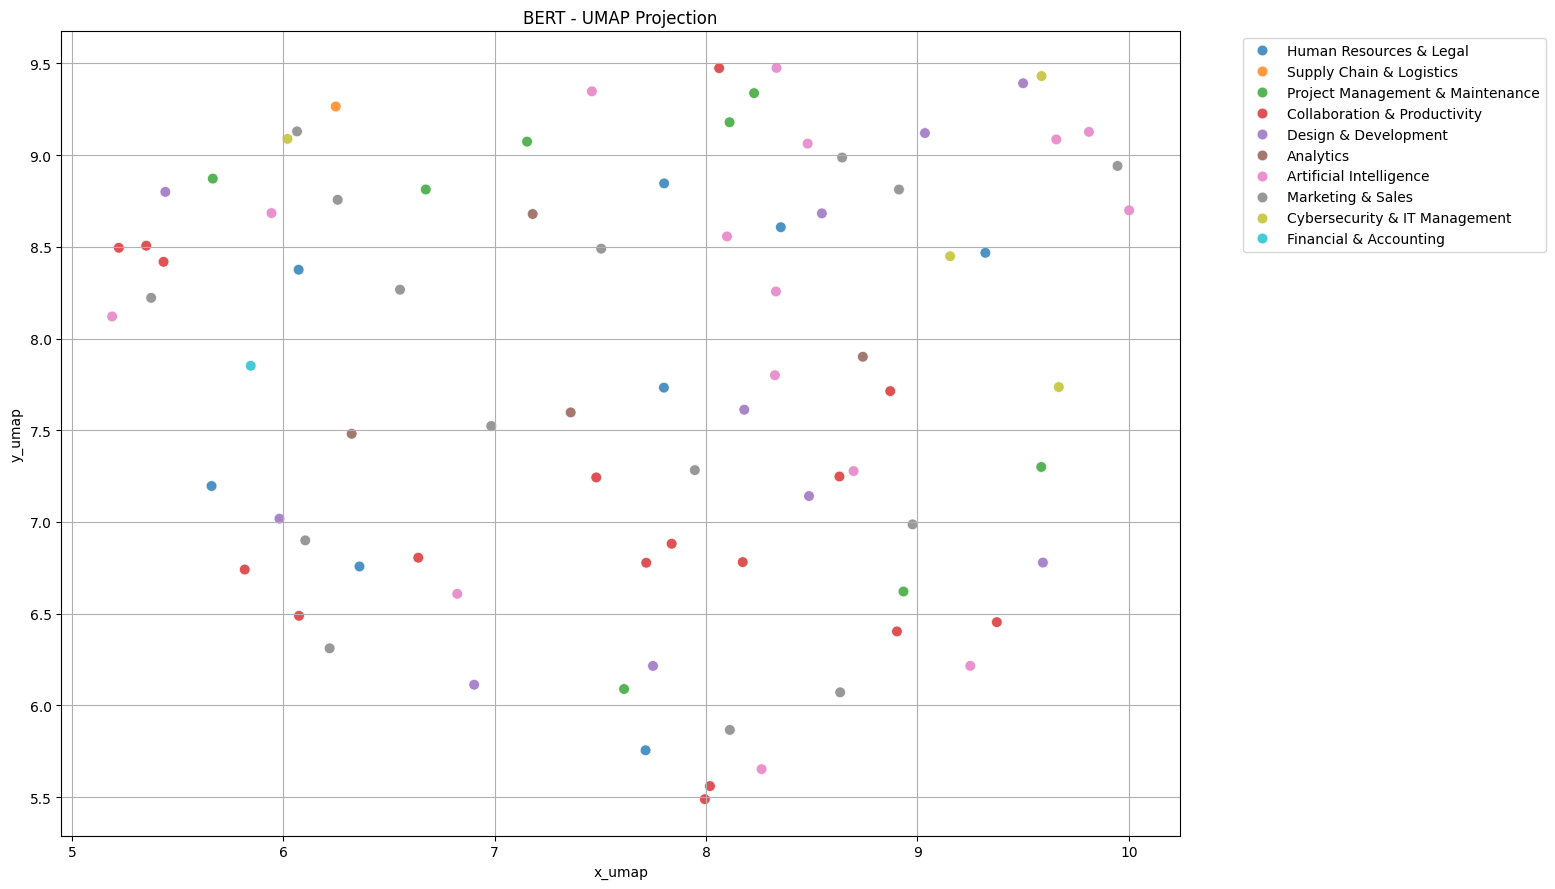


📊 BERT PCA explained variance: [0.16238713 0.13023394], Total: 29.26%


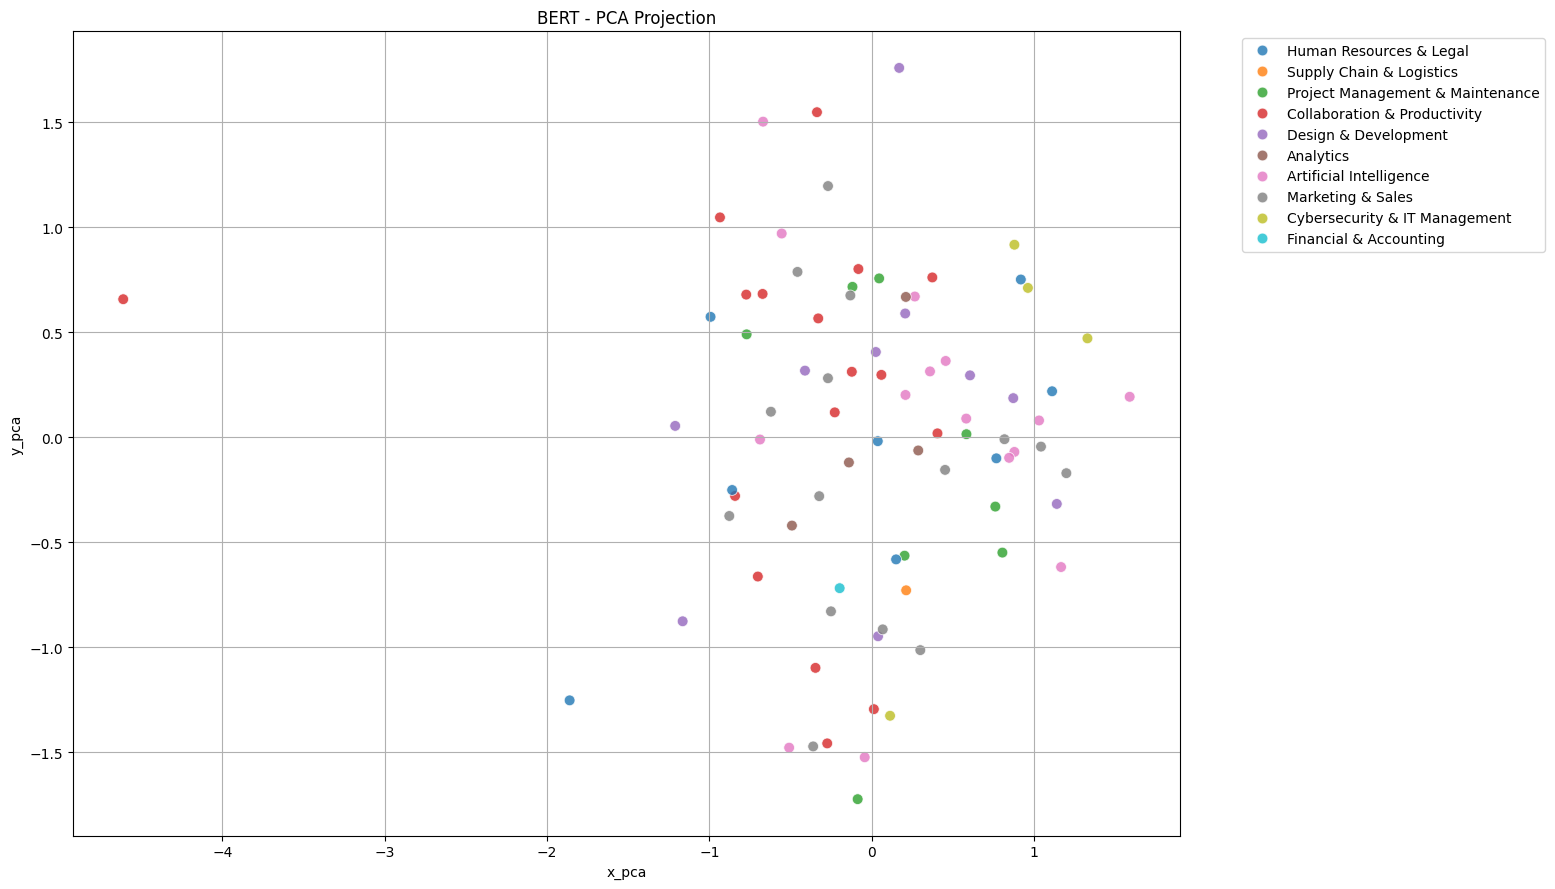

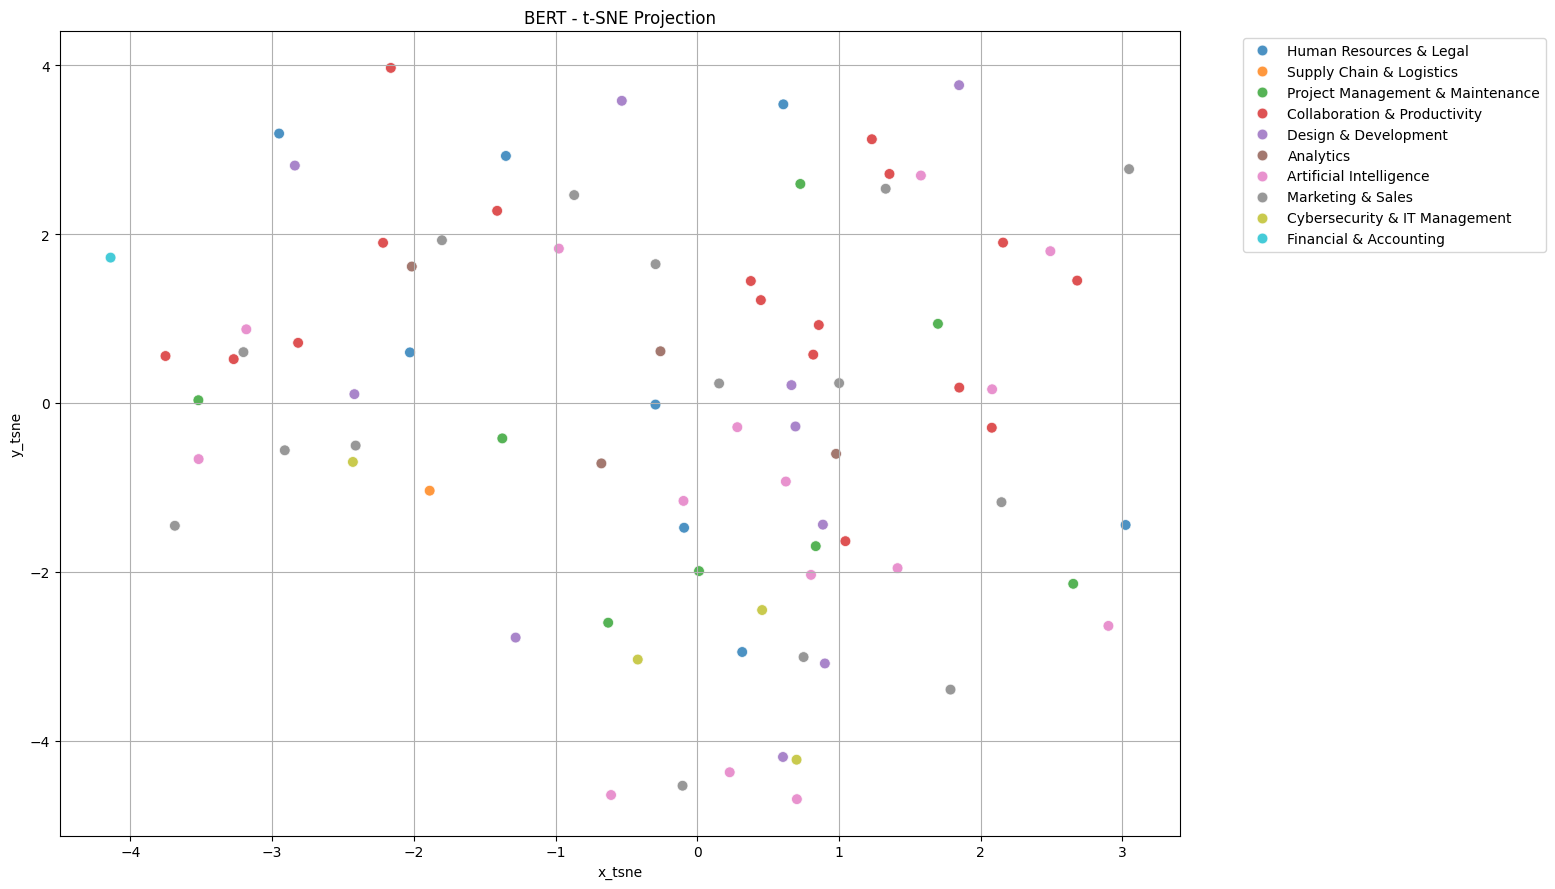

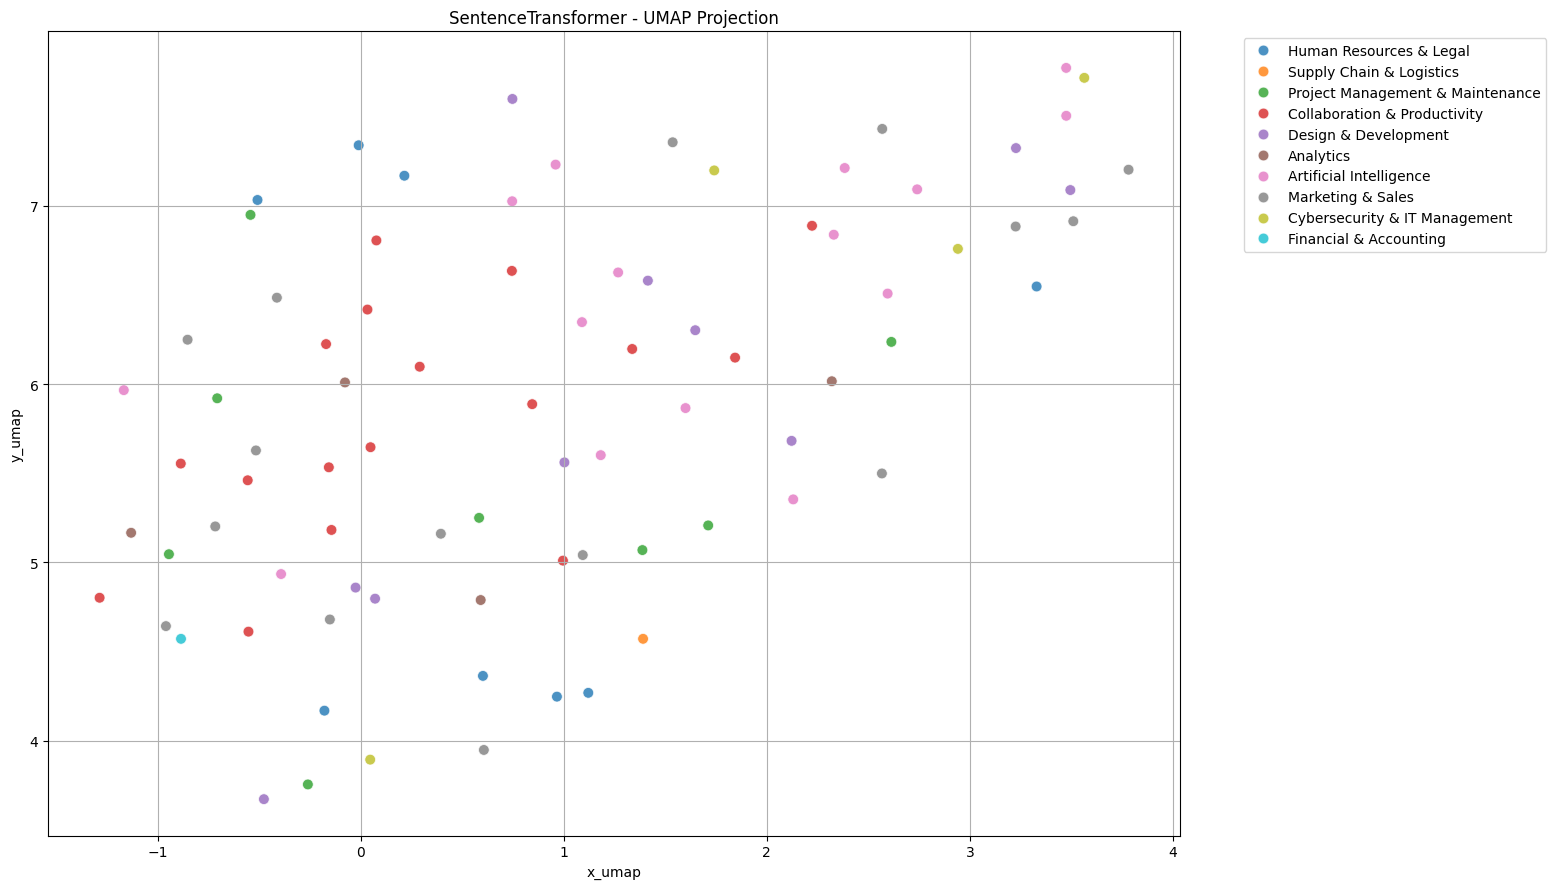


📊 SentenceTransformer PCA explained variance: [0.10044748 0.04927268], Total: 14.97%


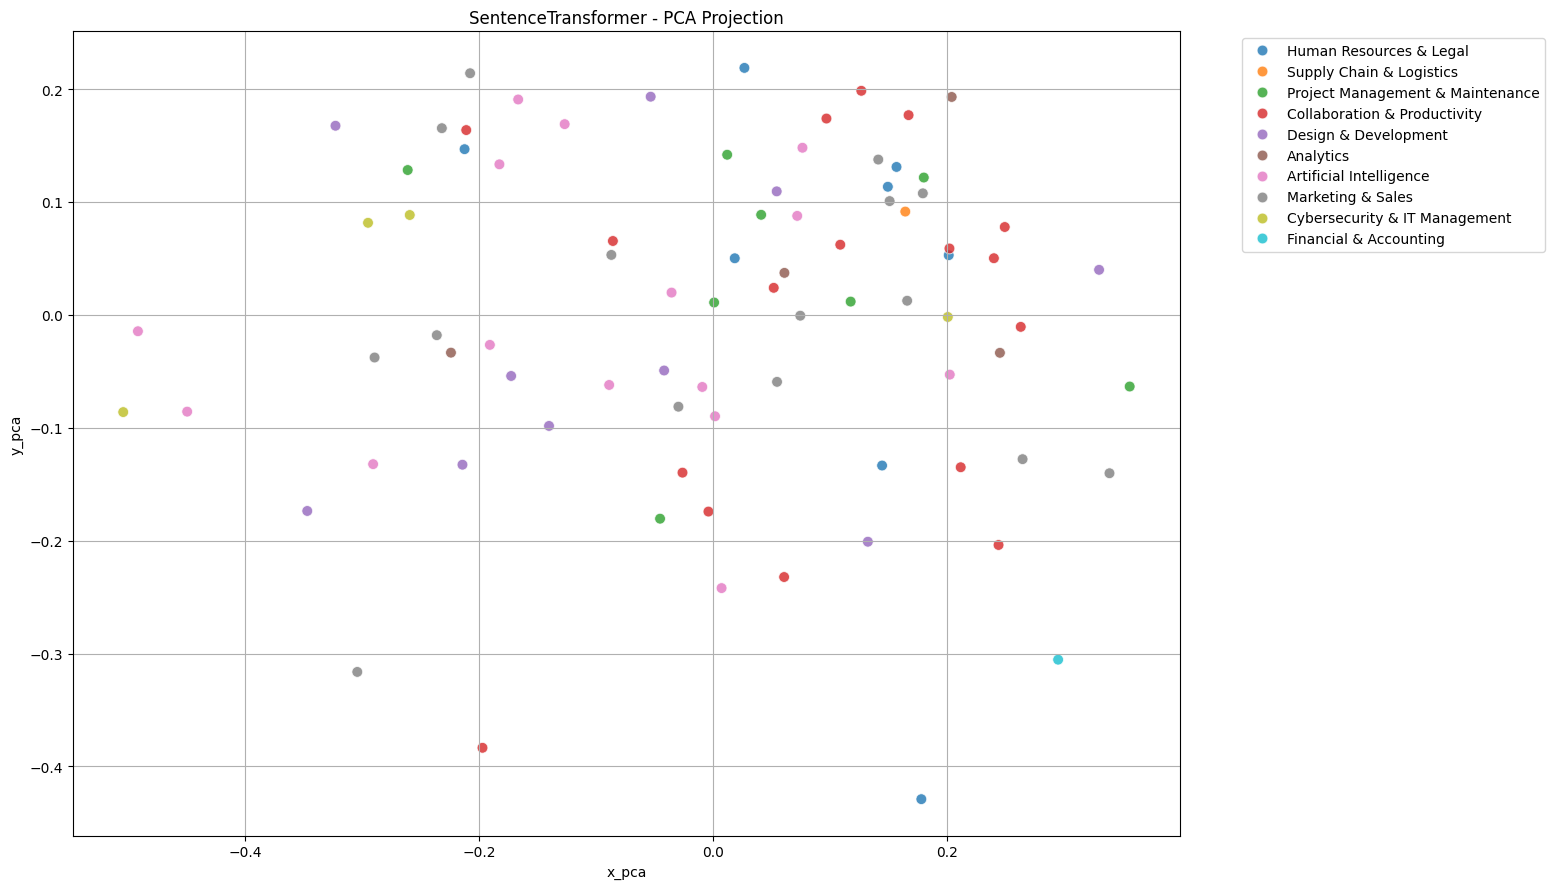

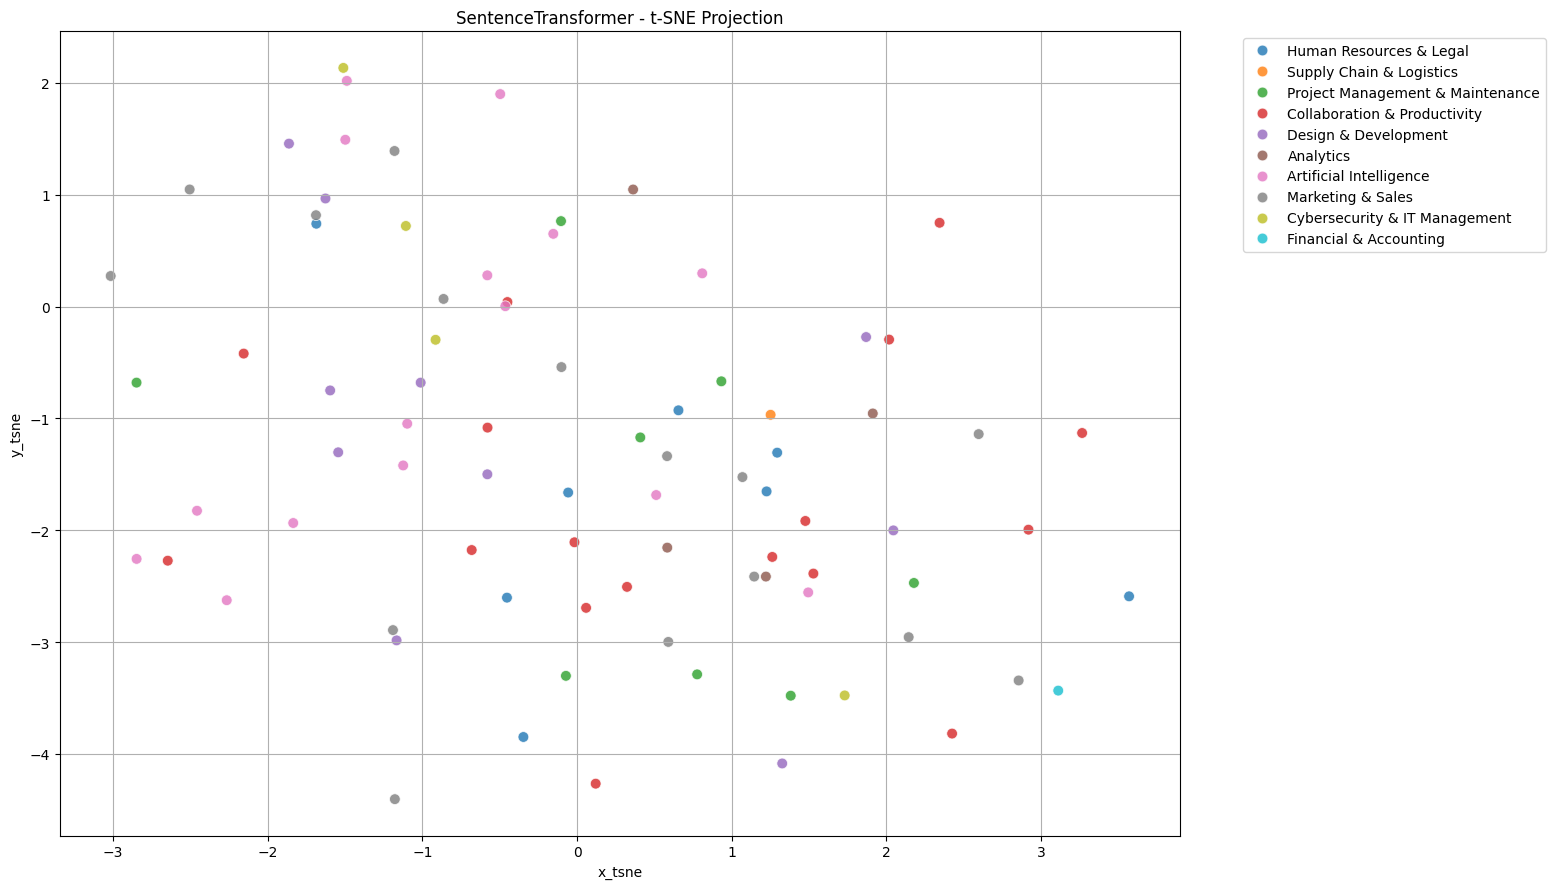

In [18]:
df_word_vis = process_and_plot_embeddings(embeddings_word, 'data/terms_of_service.csv', model_name='BERT')
df_sent_vis = process_and_plot_embeddings(embeddings_sentence, 'data/terms_of_service.csv', model_name='SentenceTransformer')

Across all three dimensionality reduction techniques — UMAP, PCA, and t-SNE — there are no clearly distinguishable clusters corresponding to the given categories. Both BERT and SentenceTransformer embeddings show substantial overlap between companies across categories, indicating that neither model captures strong or category-specific semantic distinctions in the clause-level representations. This suggests that the models may not effectively encode category-relevant features within the ToS documents.

## Network analysis of shared clauses

### N-grams base

We create an N-gram analysis of clauses simmilarity using Jaccard similarity = 0.1.

In [19]:
def split_into_clauses(text):
    text = re.sub(r'\s+', ' ', text)
    clauses = re.split(r'[.;]', text)
    clauses = [c.strip().lower() for c in clauses if c.strip()]
    return clauses

def get_ngrams(clauses, n=3):
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(n, n))
    vectorizer.fit(clauses)
    return set(vectorizer.get_feature_names_out())

def jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2) if set1 | set2 else 0.0

In [20]:
def build_similarity_graph(company_texts, threshold=0.1):
    G = nx.Graph()

    company_ngrams = {}
    for company, text in company_texts.items():
        clauses = split_into_clauses(text)
        ngram_set = get_ngrams(clauses)
        company_ngrams[company] = ngram_set
        G.add_node(company)

    for c1, c2 in combinations(company_ngrams, 2):
        sim = jaccard_similarity(company_ngrams[c1], company_ngrams[c2])
        if sim >= threshold:
            G.add_edge(c1, c2, weight=sim)

    return G

In [21]:
company_texts = {}
tos_dir = 'data/companies/'

for fname in os.listdir(tos_dir):
    if fname.endswith(".txt"):
        with open(os.path.join(tos_dir, fname), 'r', encoding='utf-8') as f:
            raw_text = f.read()
            company_name = fname.replace('.txt', '')
            cleaned_text = preprocess_text(raw_text, company_name=company_name)
            company_texts[company_name] = cleaned_text

G = build_similarity_graph(company_texts, threshold=0.1)


In [22]:
unique_categories = sorted(df['Category'].dropna().unique())
palette = sns.color_palette('tab10', len(unique_categories))
category_to_color = dict(zip(unique_categories, palette))

node_colors = [
    category_to_color.get(company_to_category.get(node, ''), (0.5, 0.5, 0.5))
    for node in G.nodes
]

legend_elements = [
    Patch(facecolor=category_to_color[cat], label=cat)
    for cat in unique_categories
]

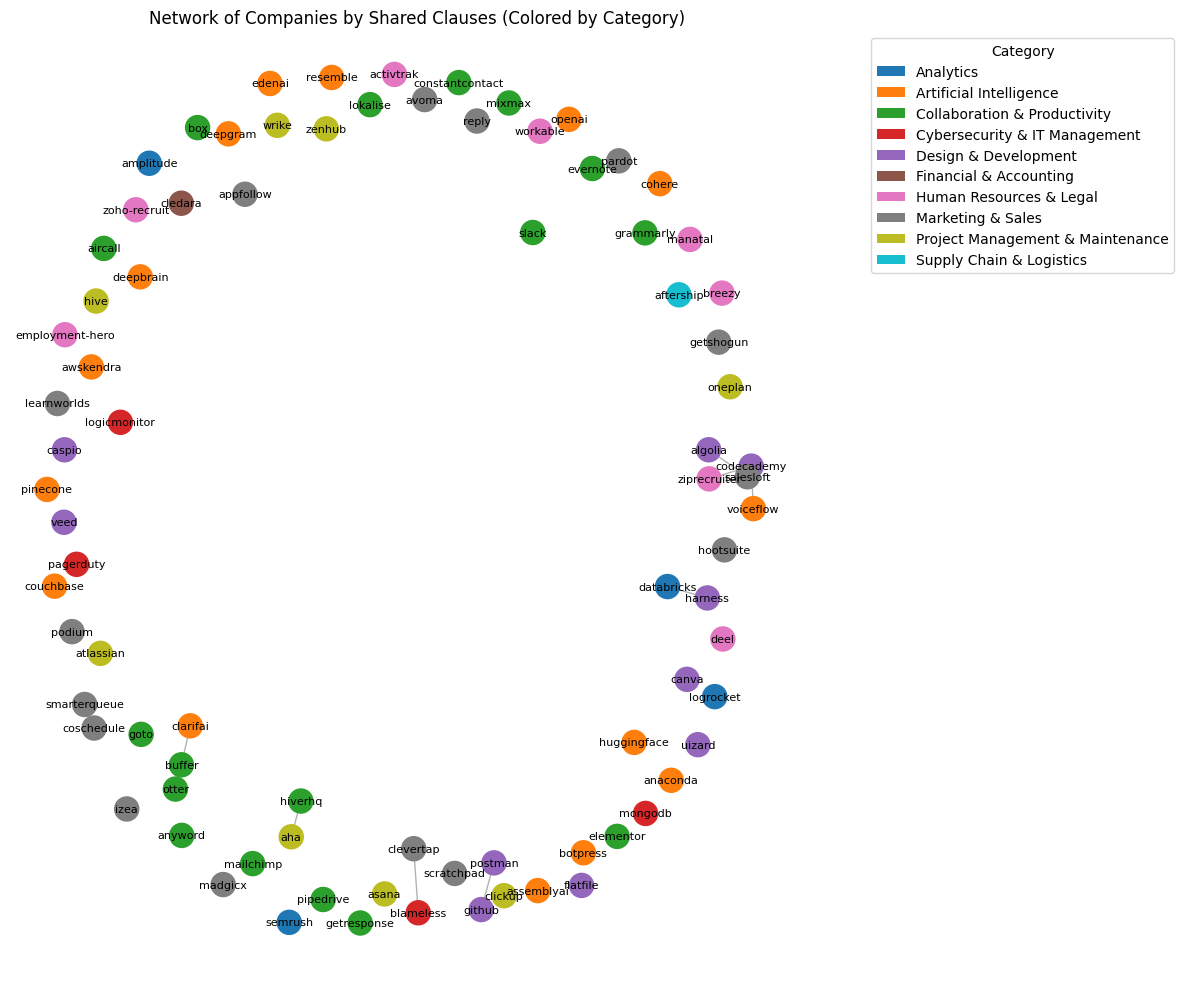

In [23]:
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 10))

nx.draw_networkx_nodes(G, pos, node_size=300, node_color=node_colors)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Network of Companies by Shared Clauses (Colored by Category)")
plt.axis('off')
plt.legend(handles=legend_elements, title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

There are also not many simmilar Terms of Service in cause of clauses. It means that 10% or more of the n-grams in the ToS of on company overlap with those in another. 
There are less simillarities then expected, but those that occur are probably because of legal templates usage. We see only few connections , mostly mixed between categories